# Вебинар 6. Двухуровневые модели рекомендаций

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings("ignore")
    
# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

# Eval recall of matching

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [15]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
def evalRecall(df_result, result_col_name, recommend_model, N):
    target_col_name = 'actual'
    df_result[result_col_name] = df_result['user_id'].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[target_col_name], k=N), axis=1).mean()

In [17]:
%%time
N_PREDICT = [20, 50, 100, 200, 500]

models = {'own_rec': recommender.get_own_recommendations,
          'similar_items': recommender.get_similar_items_recommendation,
          'als_rec': recommender.get_als_recommendations}

results = {'own_rec': [],
           'similar_items': [],
           'als_rec': []}

for n in N_PREDICT:
    for model in models.keys():
        results[model].append(evalRecall(result_eval_matcher, model, models[model], n))

CPU times: user 6min 32s, sys: 41.3 s, total: 7min 13s
Wall time: 2min 12s


In [18]:
result_eval_matcher.head()

,user_id,actual,own_rec,similar_items,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[1082212, 8090513, 8090541, 6534030, 1062572, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 917816, 985999, 880888, 819...","[5569230, 916122, 854852, 965766, 1021324, 102..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1038214, 846550, 897295, 999714, 6514160, 108...","[8090521, 1137346, 891423, 944588, 901916, 834..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[951834, 965267, 878996, 1051516, 1084036, 104..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[839419, 917816, 7147145, 9416653, 12352364, 9...","[1041688, 9803591, 830526, 925854, 839656, 103..."


In [19]:
results

{'own_rec': [0.039284276793729055,
  0.06525657038145165,
  0.09604492955885016,
  0.13537278412833254,
  0.18205324555508703],
 'similar_items': [0.017349504332920068,
  0.034017021551825316,
  0.054099945038766646,
  0.08648281794924487,
  0.13621868148845986],
 'als_rec': [0.029168852971996385,
  0.048423998789053804,
  0.06922781440206031,
  0.0984254646776446,
  0.14752202806528722]}

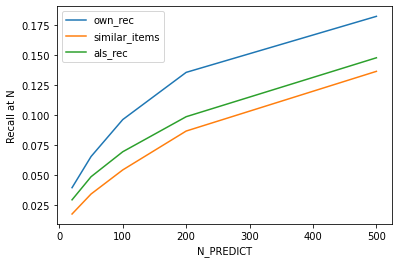

In [20]:
# Recall at N возрастает с увеличением числа кандидатов, но после N = 200 скорость возрастания снижается. 
# Т.е. оптимальное число кандидатов в диапазоне 100-200
# Из трех моделей лучший Recall для всех рассмотренных N показывает own recommender

plt.plot(N_PREDICT, results['own_rec'])
plt.plot(N_PREDICT, results['similar_items'])
plt.plot(N_PREDICT, results['als_rec'])

plt.xlabel("N_PREDICT")
plt.ylabel("Recall at N")
plt.legend(labels=["own_rec", "similar_items", "als_rec"])
plt.show()

### Обучим модель на N = 150

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]

results = {'own_rec': [],
           'similar_items': [],
           'als_rec': []}

result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
N_PREDICT = 150
for model in models.keys():
    results[model].append(evalRecall(result_eval_matcher, model, models[model], N_PREDICT))

In [23]:
results

{'own_rec': [0.11850827391946671],
 'similar_items': [0.07163777106214832],
 'als_rec': [0.08519004137703477]}

### Recall@5 of matching

In [24]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

        
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [25]:
TOPK_RECALL = 5
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.018201887674891018),
 ('als_rec', 0.012959231179562198),
 ('similar_items', 0.005591213292694886)]

In [26]:
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771269176),
 ('als_rec', 0.11901441190144119),
 ('similar_items', 0.057647605764760586)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Лучший recall как увидели выше у get_own_recommendations, допустим сгенерировали 150 кандидатов (N_PREDICT = 150)

## Подготовка данных для трейна

In [27]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher), N_PREDICT = 150
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [28]:
# Делаем unpivot кандидатов для каждого юзера
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [29]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (322650, 2) Users: 2151 Items: 4594


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [30]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

# Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_train['target'].fillna(0, inplace= True)

In [31]:
df_ranker_train.target.value_counts()

0.0    299374
1.0     15235
Name: target, dtype: int64

In [32]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 150 item_id-кандидатов

In [33]:
df_ranker_train['target'].mean()

0.048425188090614066

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

## Подготавливаем фичи для обучения модели

In [34]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [35]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


**Возможные фичи**

**Фичи user_id:**

    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:

    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**

    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [36]:
# Фичи user_id
# Средний чек
user_atv = data_train_matcher.groupby(['user_id', 'basket_id'])[['sales_value']].mean().reset_index().groupby('user_id')['sales_value'].mean()
user_atv.name = 'user_atv'
user_atv = np.round(user_atv, decimals=3)
user_atv.head()

user_id
1    3.573
2    4.335
3    4.858
4    5.119
5    5.495
Name: user_atv, dtype: float64

In [37]:
# Фичи user_id
# Частотность покупок раз/месяц
data_train_matcher['month'] = data_train_matcher['day'].apply(lambda x: (x+30)//30)

avg_month_count = data_train_matcher.groupby(['user_id']).agg({ 'month': ['min', 'max'] }).reset_index()
avg_month_count['months_count'] = avg_month_count['month','max'] - avg_month_count['month','min']
avg_month_count.drop([('month','min'), ('month','max')], axis=1, inplace=True)
avg_month_count.set_index('user_id',inplace = True)

user_freq = data_train_matcher.groupby(['user_id'])['basket_id'].count() / avg_month_count['months_count']
user_freq.name = 'monthly_user_frequency'
user_freq = np.round(user_freq, decimals=3)
user_freq.head()

user_id
1    36.722
2    19.562
3    15.938
4    10.688
5     7.941
Name: monthly_user_frequency, dtype: float64

In [38]:
# Фичи user_id
# средняя стоимость покупок в месяц
user_sales_val = data_train_matcher.groupby(['user_id'])['sales_value'].sum().rename('monthly_user_salesval') / avg_month_count['months_count']
user_sales_val.name = 'monthly_user_salesval'
user_sales_val = np.round(user_sales_val, decimals=3)
user_sales_val.head()

user_id
1    124.735
2     77.804
3     77.049
4     55.653
5     36.946
Name: monthly_user_salesval, dtype: float64

In [39]:
# Фичи item_id
# Среднее кол-во покупок item_id в неделю
item_per_week = data_train_matcher.groupby(['item_id'])['quantity'].sum().rename('item_per_week') / data_train_matcher['week_no'].max() 
item_per_week = np.round(item_per_week, decimals=3)
item_per_week.head()

item_id
117847    0.576
818981    0.906
819255    2.776
819308    3.682
819400    0.929
Name: item_per_week, dtype: float64

In [40]:
# Фичи item_id
# Средняя частота item в корзине
item_freq_per_basket = data_train_matcher.groupby(['item_id']).agg('user_id').count().rename('item_freq_per_basket')/data_train_matcher.basket_id.nunique()
item_freq_per_basket = np.round(item_freq_per_basket, decimals=4)
item_freq_per_basket.head()

item_id
117847    0.0003
818981    0.0004
819255    0.0012
819308    0.0012
819400    0.0004
Name: item_freq_per_basket, dtype: float64

In [41]:
# Фичи item_id
# Среднее кол-во item в корзине
item_quantity_per_basket = data_train_matcher.groupby(['item_id']).agg('quantity').sum().rename('item_quantity_per_basket')/data_train_matcher.basket_id.nunique()
item_quantity_per_basket = np.round(item_quantity_per_basket, decimals=4)
item_quantity_per_basket.head()

item_id
117847    0.0003
818981    0.0005
819255    0.0014
819308    0.0019
819400    0.0005
Name: item_quantity_per_basket, dtype: float64

In [42]:
# Фичи item_id
# Цена (Можно посчитать из retil_train.csv) - цена есть в таблице взаимодействий
item_price = data.groupby(['item_id']).agg({'quantity': 'sum', 'sales_value': 'sum'})
item_price = item_price['sales_value'] / item_price['quantity']
item_price.name = 'item_price'
item_price = np.round(item_price, decimals=2)
item_price.head()

item_id
25671    3.49
26081    0.99
26093    1.59
26190    1.54
26355    0.99
Name: item_price, dtype: float64

In [43]:
# Фичи item_id
# Среднее кол-во покупок 1 товара в категории в неделю
data_categ = pd.merge(data_train_matcher, item_features, how='inner', on='item_id')

categ_freq_ = data_categ.groupby(['department'])['quantity'].sum()
categ_item_freq_ = data_categ.groupby(['department','item_id'])['quantity'].sum().reset_index()

categ_freq = pd.merge(categ_item_freq_, categ_freq_, on='department')
categ_freq['category_freq'] = categ_freq['quantity_y'] / data_train_matcher['week_no'].max() / categ_freq['quantity_x']
categ_freq.set_index('item_id', inplace=True)
category_freq = categ_freq['category_freq']
category_freq = np.round(category_freq, decimals=3)
category_freq.head()

item_id
1101805    0.012
819978     0.666
823862     2.058
825621     8.932
827656     1.116
Name: category_freq, dtype: float64

In [44]:
# Фичи item_id
# (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
freq_ratio_1 = item_per_week / category_freq
freq_ratio_1.name = 'freq_ratio_1'
freq_ratio_1 = np.round(freq_ratio_1, decimals=3)
freq_ratio_1.head()

item_id
117847    0.413
818981    0.015
819255    0.861
819308    1.288
819400    0.016
Name: freq_ratio_1, dtype: float64

In [45]:
# Фичи item_id
# Цена / Средняя цена товара в категории
avg_categ_price = data_categ.groupby(['commodity_desc'])['price'].mean()
data_categ_avg = pd.merge(data_categ, avg_categ_price, on='commodity_desc', suffixes=('_x', '_y'))
data_categ_avg = data_categ_avg.groupby(['item_id']).agg({'price_x': 'mean', 'price_y': 'mean'})

price_diff = data_categ_avg['price_x'] / data_categ_avg['price_y']
price_diff.name = 'price_diff'
price_diff = np.round(price_diff, decimals=3)
price_diff.head()

item_id
117847    0.919
818981    1.013
819255    0.818
819308    0.746
819400    0.443
Name: price_diff, dtype: float64

In [46]:
#Фичи пары user_id - item_id
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

categ_user_freq_ = data_categ.groupby(['user_id', 'department'])['quantity'].sum().reset_index()
categ_user_freq_['category_freq'] = categ_user_freq_['quantity'] / data_train_matcher['week_no'].max()

categ_user_freq = pd.merge(categ_user_freq_, categ_freq_, on='department')
categ_user_freq['avg_weekly_freq'] = categ_user_freq['quantity_y'] / data_train_matcher['week_no'].max()
categ_user_freq['freq_ratio_2'] = categ_user_freq['category_freq'] / categ_user_freq['avg_weekly_freq']

user_dep_ratio_2 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_2'], axis=1)
user_dep_ratio_2 = np.round(user_dep_ratio_2, decimals=5)
user_dep_ratio_2.head()

,user_id,department,freq_ratio_2
0,1,DELI,0.00117
1,2,DELI,0.00033
2,3,DELI,0.00012
3,4,DELI,0.00003
4,5,DELI,0.00015


In [47]:
#Фичи пары user_id - item_id
# (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

categ_user_freq['freq_ratio_3'] = categ_user_freq['category_freq'] - categ_user_freq['avg_weekly_freq']
user_dep_ratio_3 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_3'], axis=1)
user_dep_ratio_3 = np.round(user_dep_ratio_3, decimals=2)
user_dep_ratio_3.head()

,user_id,department,freq_ratio_3
0,1,DELI,-392.53
1,2,DELI,-392.86
2,3,DELI,-392.94
3,4,DELI,-392.98
4,5,DELI,-392.93


## Добавляем сгенерированные фичи в таблицы 

In [48]:
user_features = user_features.merge(user_atv, how='left', on='user_id', suffixes=(False, False))
user_features = user_features.merge(user_freq, how='left', on='user_id', suffixes=(False, False))
user_features = user_features.merge(user_sales_val, how='left', on='user_id', suffixes=(False, False))

In [49]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,user_atv,monthly_user_frequency,monthly_user_salesval
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3.573,36.722,124.735
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,4.708,20.263,86.377
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,5.066,35.412,160.825
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,6.894,54.062,313.217
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.596,14.812,54.719


In [50]:
item_features = item_features.merge(item_per_week, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(category_freq, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(freq_ratio_1, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(price_diff, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(item_freq_per_basket, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(item_quantity_per_basket, how='left', on='item_id', suffixes=(False, False))

In [51]:
# Некоторых товаров не было в транзакциях тренировочного датасета
item_features[item_features['category_freq'].isna()].head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,category_freq,freq_ratio_1,price_diff,item_freq_per_basket,item_quantity_per_basket
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,NaN,NaN,NaN,NaN,NaN,NaN
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN,NaN,NaN,NaN,NaN,NaN
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,NaN,NaN,NaN,NaN,NaN,NaN
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,NaN,NaN,NaN,NaN,NaN,NaN
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left', suffixes=(False, False))
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left', suffixes=(False, False))

In [53]:
df_ranker_train = pd.merge(df_ranker_train, user_dep_ratio_2, on=['user_id', 'department'], how='left')
# df_ranker_train = pd.merge(df_ranker_train, user_dep_ratio_3, on=['user_id', 'department'], how='left')

In [54]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [55]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'item_per_week',
 'category_freq',
 'freq_ratio_1',
 'price_diff',
 'item_freq_per_basket',
 'item_quantity_per_basket',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_atv',
 'monthly_user_frequency',
 'monthly_user_salesval',
 'freq_ratio_2']

## Обучение модели ранжирования

In [56]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=12,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [57]:
df_ranker_predict = df_ranker_train.copy()

In [58]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# Evaluation on test dataset
- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

In [59]:
# Преобразуем тестовый датасет в нужный формат
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [60]:
%%time
# выбранный ранее N_PREDICT = 150, лучшая модель own_recommend
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.6 s, sys: 214 ms, total: 5.82 s
Wall time: 5.86 s


In [61]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.14441176470588235)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [62]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [63]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [66]:
# precision  и моделью без генерации доп фичейвырос в двухуровневой модели по сравнению с одноуровневым own_recommend и моделью без генерации доп фичей
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.19080939947780678)
('own_rec', 0.14441176470588235)
